# Comparaison de méthodes de réduction de dimension : PCA, t-SNE et UMAP sur un jeu de données réel
## Résumé du projet

Problématique : Quand on a des données multivariées (images, textes, mesures biologiques...), peut-on visualiser leur structure en 2D ou 3D tout en conservant leur forme originale ? Quelles méthodes fonctionnent le mieux ?

Méthodes :

PCA (analyse en composantes principales)

t-SNE (t-distributed stochastic neighbor embedding)

UMAP (Uniform Manifold Approximation and Projection)

Jeu de données : Iris, Digits (MNIST réduit), ou Penguins

In [24]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

## PCA (Analyse en Composantes Principales)

Soit $X \in \mathbb{R}^{n \times d}$ de $ \text{n données et d variables}$ d'esperance nulle.

La matrice de covariance de X :

$$
S = \frac{1}{n} X^\top X
$$

On cherche $W \in \mathbb{R}^{d \times k}$ qui maximise :

$$
\max_{W} \operatorname{Tr}(W^\top S W) \quad \text{sous la contrainte : } \quad W^\top W = I_k
$$



## Descente de gradient projetée pour minimiser $\mathcal{L}(W)$

Soit la fonction de coût définie par :

$$
\mathcal{L}(W)= -\operatorname{Tr}(W^\top S W)
$$

où \(S \in \mathbb{R}^{d \times d}\) est la matrice de covariance, et \(W \in \mathbb{R}^{d \times k}\) est la matrice de projection que l'on souhaite optimiser.

L'objectif est de minimiser $\mathcal{L}(W)$ sous la contrainte d'orthonormalité suivante :

$$
W^\top W = I_k
$$

Cette contrainte signifie que les colonnes de \(W\) doivent rester orthonormales tout au long de l'optimisation.

---

**Méthode : descente de gradient projetée**

- À chaque itération \(t\), calculer le gradient de \(L\) par rapport à \(W_t\) :

$$
\nabla \mathcal{L}(W_t) = -2 S W_t
$$

- Effectuer une mise à jour temporaire par descente de gradient :

$$
W_{\text{temp}} = W_t - \eta \nabla \mathcal{L}(W) = W_t + 2 \eta S W_t
$$

où $\eta > 0$ est le pas de descente.

- Projeter la matrice \(W_{\text{temp}}\) sur l'ensemble des matrices ayant des colonnes orthonormales en effectuant une décomposition QR :

$$
W_{\text{temp}} = Q R \quad \Rightarrow \quad W_{t+1} = Q
$$

Ainsi, $W_{t+1}$ satisfait la contrainte

$$
W_{t+1}^\top W_{t+1} = I_k.
$$

La condition d'arrêt de l'algorithme sera basée sur la différence entre deux itérations successives. 

On arrêtera l'algorithme dès que :

$$
\| W_{t+1} - W_t \|_F < \varepsilon
$$

où $\|\cdot\|_F$ désigne la norme de Frobenius, et $\varepsilon > 0$ est un petit seuil fixé à l'avance.

Cela garantit que les mises à jour deviennent suffisamment petites, indiquant la convergence.



## Gradient de $\mathcal{L}(W)$

Soit la fonction :

$$
f(W) = \operatorname{Tr}(W^\top A W)
$$

avec $W \in \mathbb{R}^{d \times k}  et  A \in \mathbb{R}^{d \times d}$ symétrique.


### Étape 1 : écriture de la trace

La trace peut s’écrire comme :

$$
f(W) = \operatorname{Tr}(W^\top A W) = \sum_{i=1}^k w_i^\top A w_i
$$

où  $w_i$ est la $i$-ème colonne de $W$.


### Étape 2 : gradient colonne par colonne

Le gradient de $ f $par rapport à chaque colonne $w_i $ est :

$$
\nabla_{w_i} f = 2 A w_i
$$

car $ w_i^\top A w_i $ est une forme quadratique.


### Étape 3 : gradient total

En regroupant les gradients colonnes par colonnes, on obtient :

$$
\nabla_W f = 2 A W
$$


### Remarque

Si A n’est pas symétrique, on aurait

$$
\nabla_W f = (A + A^\top) W
$$

Mais pour une matrice de covariance $S ,  S = S^\top $, donc la formule simplifiée s’applique.


### Application à

$$
L(W) = - \operatorname{Tr}(W^\top S W)
$$

Le gradient est alors :

$$
\nabla_W L = - 2 S W
$$


In [25]:
X = load_digits()
X = X.data
X_centre = X - X.mean(axis = 0)
#X_centre.mean()
n, d = X_centre.shape

In [36]:
from numpy import random as rdm
from numpy.linalg import norm
k=2
W0 = rdm.rand(d,k)
S = 1/n * np.dot(X_centre.T,X_centre)

def grad(W):
    return -2* S@W
def lossfunction(W0 = W0, N_iter = 1000, eps = 1e-3, r = 0.01):
    Wt = W0
    Wt1 = np.linalg.qr(Wt - r*grad(Wt))[0]
    k= 0
    while norm(Wt1-Wt)>eps and  k<1000:
        Wtmp = Wt1
        Wt1 = np.linalg.qr(Wt - r*grad(Wt))[0]
        Wt = Wtmp
        k+=1
    return norm(Wt1-Wt)<=eps,k,Wt1

In [41]:
W = lossfunction()[-1]

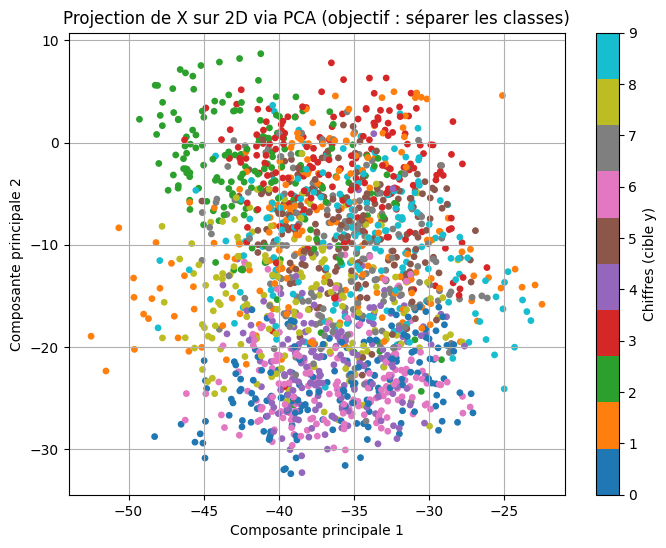

In [43]:
Z = X@W

digits = load_digits()
X = digits.data
y = digits.target  # <-- c’est ici qu’est la cible, pas dans X

# Supposons que tu as déjà calculé Z = X_centre @ W_opt

plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='tab10', s=15)
plt.title("Projection de X sur 2D via PCA (objectif : séparer les classes)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Chiffres (cible y)")
plt.grid(True)
plt.show()

array([[1.00000000e+00, 4.02344185e-18],
       [4.02344185e-18, 1.00000000e+00]])